### ML2 TP01 - Exercise 7.9.10

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

### Read in the College dataset. 
- Convert Private Y/N into dummy var
- Omit Y variable from features 

In [10]:
# read and preprocess the data
df = pd.read_csv('College.csv', index_col = 0)
df['Private'] = df['Private'].map({'Yes': 1, 'No': 0})
y = df['Outstate']
X = df.drop('Outstate', axis = 1)
featurelist = list(df.columns)
print(featurelist)

['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate']


# A)  
Split the data into a training set and a test set. Using out-of-state
tuition as the response and the other variables as the predictors,
perform forward stepwise selection on the training set in order
to identify a satisfactory model that uses just a subset of the
predictors.

### Split data into training and testing. Perform Forward Selection to choose features
- call the mlxtend library to use the SequentialFeatureSelector and set the argument forward TRUE

In [13]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# random_state arg enables the data split to be the same
# for consistency while troubleshooting
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# use LinearRegression from Sklearn as the estimator to measure the 
# importance of x vars
n=14
sfs = SFS(LinearRegression(),k_features=n,forward=True,floating=False,scoring='r2',cv=5)
                # n equal data portions to train the model where
                  # the model trains on n-1 and test on the remaining node.
                  # this is repeated for each fold for a robust performance

sfs = sfs.fit(X_train, y_train)

selected_features = X_train.columns[list(sfs.k_feature_idx_)]
print('Of the ', len(featurelist), ' features in the dataset, the best features to consider in a ', n ,' feature model are ', selected_features)

Of the  18  features in the dataset, the best features to consider in a  14  feature model are  Index(['Private', 'Apps', 'Accept', 'Top10perc', 'F.Undergrad', 'Room.Board',
       'Books', 'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni',
       'Expend', 'Grad.Rate'],
      dtype='object')


In [16]:
# get the selected features
Xtrain_selected = Xtrain[selected_features]
Xtest_selected = Xtest[selected_features]
Xtrain_selected

,Private,Apps,Accept,Top10perc,F.Undergrad,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Sweet Briar College,1,462,402,36,527,6000,500,600,91,99,6.5,48,18953,61
Eureka College,1,560,454,36,484,3450,330,670,62,87,10.6,31,9552,53
Manhattanville College,1,962,750,21,830,6550,450,400,97,97,11.3,24,11291,70
Lenoir-Rhyne College,1,979,743,25,1188,4000,400,1000,88,92,12.0,20,8539,66
West Liberty State College,0,1164,1062,12,2138,2890,600,1210,33,33,16.3,10,4249,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virginia Wesleyan College,1,1470,900,20,1130,5100,500,550,70,81,15.7,14,7804,68
Winthrop University,0,2320,1805,24,3395,3392,580,2150,71,80,12.8,26,6729,59
Bucknell University,1,6548,3813,49,3316,4750,800,1200,95,97,14.2,36,13675,93
Greensboro College,1,608,494,10,649,3770,550,1300,64,80,13.0,31,7949,39


# B)
 Fit a GAM on the training data, using out-of-state tuition as
the response and the features selected in the previous step as
the predictors. Plot the results, and explain your findings

- Use the pygam library to fit the data to a GAM model
- The s(1), s(2), s(3), ... s(n) in pygam's LinearGAM refer to the smoothing terms used to model non-linear relationships between predictor variables and the response variable.

In [18]:
#call the pygam library to use LinearGAM
from pygam import LinearGAM

# count of splines is set to be 30 for each feature. 
gam = LinearGAM(n_splines=30).fit(Xtrain_selected[selected_features], ytrain)

# grid search the model, choose the best lambda (regularization)
lam = np.logspace(-2, 2, 2)
lams = [lam] * n
gam.gridsearch(Xtrain_selected, ytrain, lam=lams)

gam.summary()

100% (16384 of 16384) |##################| Elapsed Time: 0:50:39 Time:  0:50:39


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     61.0471
Link Function:                     IdentityLink Log Likelihood:                                 -9831.5576
Number of Samples:                          621 AIC:                                            19787.2093
                                                AICc:                                           19801.2316
                                                GCV:                                          3632863.0577
                                                Scale:                                        2996264.5627
                                                Pseudo R-Squared:                                   0.8316
Feature Function                  Lam

In [20]:
#use dictionary to know what each s references back to in the GAM summary
dict(zip(['s' + str(i) for i in range(len(selected_features))], selected_features))

{'s0': 'Private',
 's1': 'Apps',
 's2': 'Accept',
 's3': 'Top10perc',
 's4': 'F.Undergrad',
 's5': 'Room.Board',
 's6': 'Books',
 's7': 'Personal',
 's8': 'PhD',
 's9': 'Terminal',
 's10': 'S.F.Ratio',
 's11': 'perc.alumni',
 's12': 'Expend',
 's13': 'Grad.Rate'}

### Psudo R Square of the model on train set is 0.83

# C) 
Evaluate the model obtained on the test set, and explain the
results obtained.

In [21]:
#performance on the test set
predictions = gam.predict(Xtest[selected_features]) 
mse = mean_squared_error(ytest, predictions) #evaluation measure to minimize: Mean Square Error
r2 = r2_score(ytest, predictions)            #evaluation measure to maximize (without overfitting)
print("MSE: {} ".format(mse))
print("R square: {:.4f} ".format(r2))

MSE: 3417752.151004729 
R square: 0.7946 


# D) 

 For which variables, if any, is there evidence of a non-linear
relationship with the response?

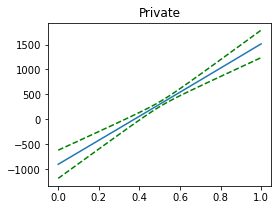

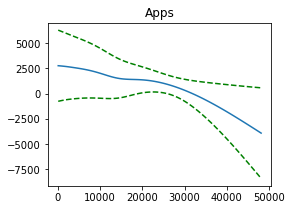

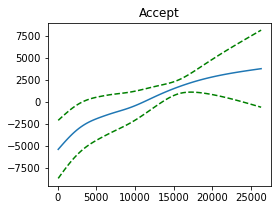

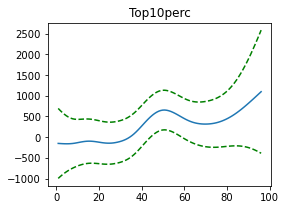

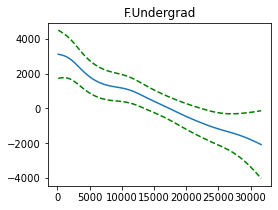

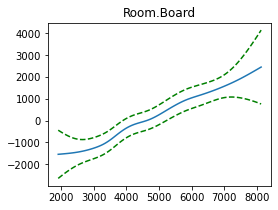

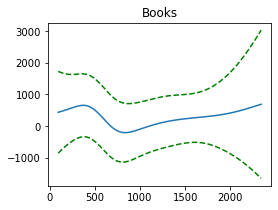

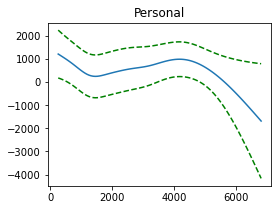

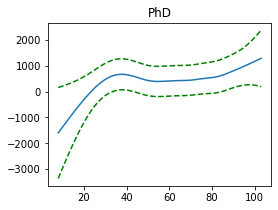

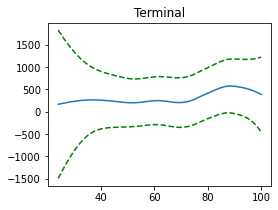

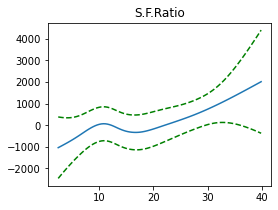

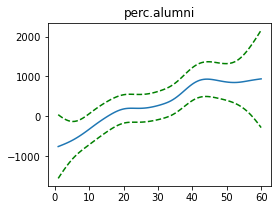

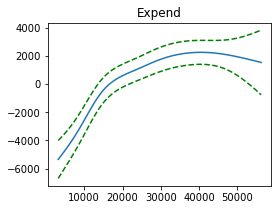

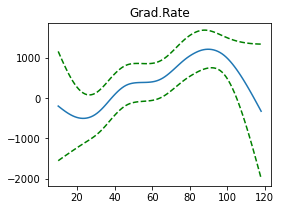

In [23]:
# Partial Dependence Plot of each feature
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    # get the value adn confidence intercal
    XX = gam.generate_X_grid(term=i)
    value, CI = gam.partial_dependence(term=i, X=XX, width=0.95)
    feature = term.feature
    # plot
    plt.figure(figsize = (4,3))
    plt.title(selected_features[i])
    plt.plot(XX[:, feature], CI, c = 'g', ls = '--')
    plt.plot(XX[:, feature], value)
    plt.show()